In [1]:
import numpy as np
%pylab
%matplotlib inline

from Functions import functions as f
import skimage.io as sk
from collections import Counter


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\ijung\anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


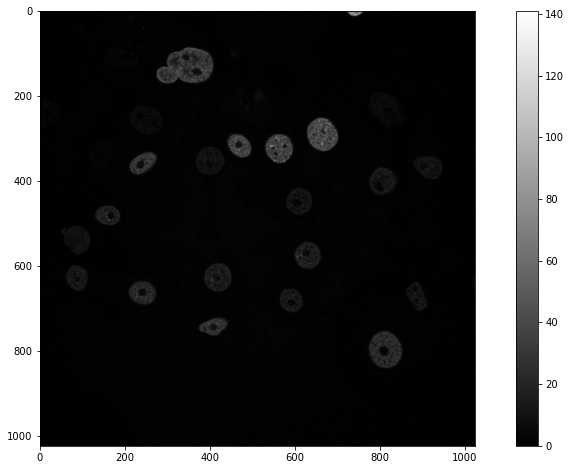

In [2]:
img = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Bild laden
f.show_image(img, 15, 8)

/Users/johannamoeller/PycharmProjects/2021-topic-04-team-04/Functions/functions.py:55: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
/Users/johannamoeller/PycharmProjects/2021-topic-04-team-04/Functions/functions.py:55: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
/Users/johannamoeller/PycharmProjects/2021-topic-04-team-04/Functions/functions.py:55: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
/Users/johannamoeller/PycharmProjects/2021-topic-04-team-04/Functions/functions.py:69: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])) # adds euclidean distance to list


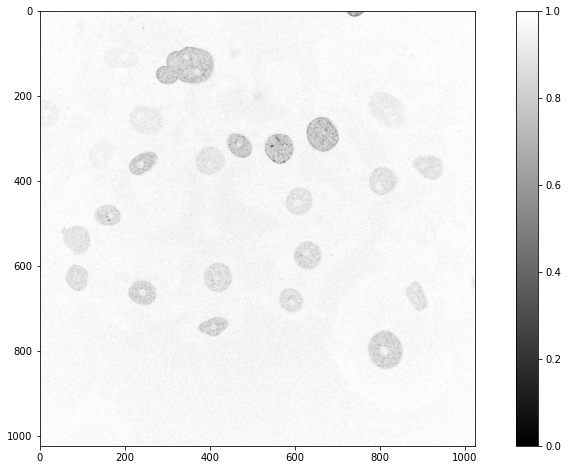

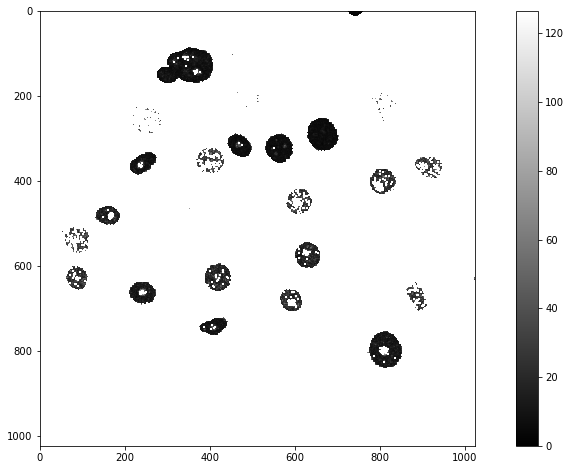

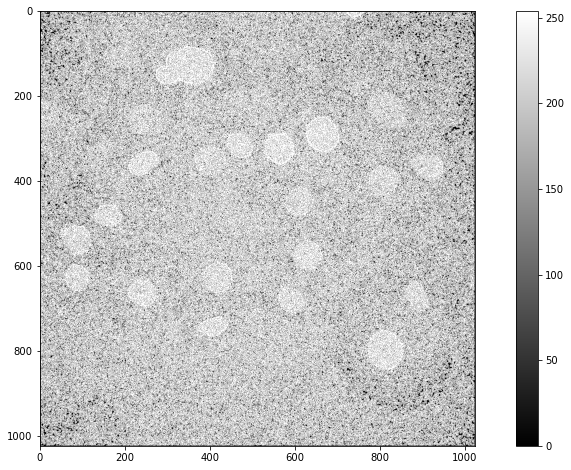

In [8]:
#calculates similarity of every pixel to its nxn neighborhood (standard deviation)
sd = f.standarddeviation(img,3) # apply method for testing
sd = sd/max(sd.flatten()) # normes standard deviation
similarity = 1-sd # calculates similarity
f.show_image(similarity, 15, 8)

#calculates relative euclidean distance of pixel to its nxn neighborhood
eurel = f.euclidean_relative(img, 3)
f.show_image(eurel, 15, 8)

#calculates relative euclidean distance of pixel to its nxn neighborhood
eu = f.euclidean_n(img, 3)
f.show_image(eu, 15, 8)

In [4]:

def seeds(img, T1, T2): # automatic seed selection algorithm
    result = numpy.zeros(img.shape)
    sd_seeds = f.standarddeviation(img,3) # standard deviation
    sd_flat = sd_seeds.flatten() # standard deviation as 1D-array
    similarity_seeds = 1 - sd_seeds/max(sd_flat) # calculates similarity of every pixel to its neighbors
    eurel_seeds = f.euclidean_relative(img, 3) # relative euclidean distance of every pixel to its neighbors
    for p in ndindex(img.shape): # border pixel value is zero
        if similarity_seeds[p] > T1 and eurel_seeds[p] < T2: # compares pixel with threshold
            result[p] = 1 # assigns value 1 to seeds
    return result



#seed_final = seeds(img, 0.4, 40)
#f.show_image(seed_final, 15, 8)



In [5]:
def seed_merging(img):
    regions = np.zeros(img.shape) #creates new array for region numbers for every image pixel
    count = 1 #keep track of region number
    for p in np.ndindex(img.shape): #iterates over every pixel of the image
        if img[p] == 1: #tests if pixel is seed
            if p[0]-1 >= 0 and p[1]-1 >= 0 and p[0]+1 <= img.shape[0] -1 and p[1]+1 <= img.shape[1] -1: # no calculation of border pixels
                for q in np.ndindex(3, 3): # iterates over 3x3 neighborhood
                    i = p[0]-1 + q[0]
                    j = p[1]-1 + q[1]
                    if regions[i,j] != 0: #tests if neighbors are also seeds
                        regions[p] = regions[i,j] # merge neighboring seeds; wird zur letzten abgefragten Region zugeordnet
                if regions[p] == 0: #tests if no neighbors are seeds
                    regions[p] = count #creates new region from new seed
                    count += 1
    return regions

test = seed_merging(seeds(f.img_resize(img, 500, 500), 0.4, 40))
print(test)

C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\functions.py:55: RuntimeWarning: invalid value encountered in double_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\functions.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list


[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...  108.  108.    0.]
 [   0.    0.    0. ...  108.  108.    0.]
 ...
 [   0.    0.    0. ... 1900. 1900.    0.]
 [   0. 2574.    0. ...    0. 1900.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]


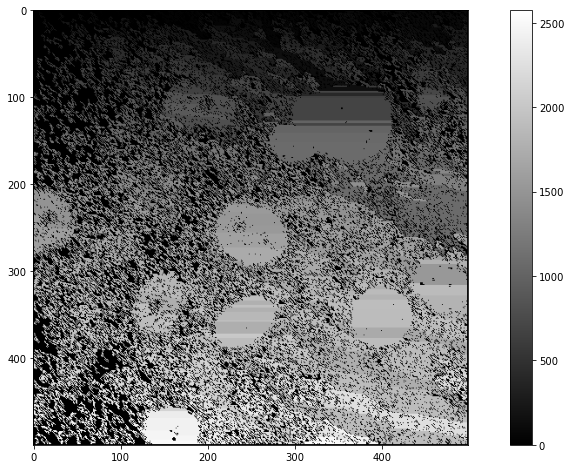

In [9]:
#reduce number of starting regions for region growing by only considering starting regions with more than T seeds
def decrease_region_number(img, T):
    list = Counter(img.flatten()) #counts number of seeds in region
    d_seeds = img.copy() 
    for i in range(1, int(np.amax(img))): #iterates over every region
        if list[i] <= T:#if number of seeds is smaller than threshold, delete region
            for p in np.ndindex(img.shape):
                if img[p] == i:
                    d_seeds[p] = 0
    return d_seeds

test2 = decrease_region_number(test, 10)
f.show_image(test2, 15, 8)

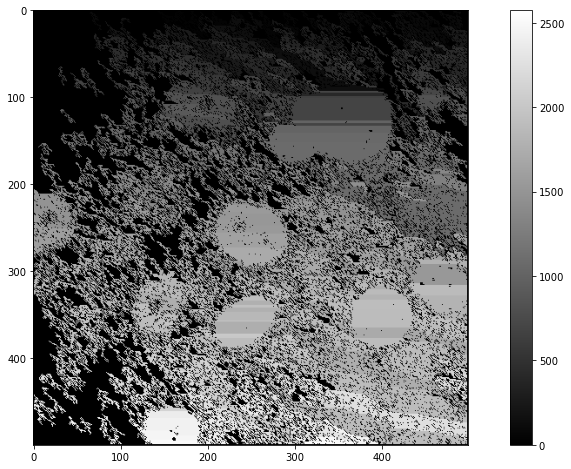

In [11]:
test3 = decrease_region_number(test, 50)
f.show_image(test3, 15, 8)

In [12]:
def find_neighbors(regions):
    Ne = []
    for p in np.ndindex(regions.shape):
        if regions[p] != 0: # Pixels with region
            if p[0] > 0: # Add neighbours to list T, left
                a = (p[0]-1, p[1])
                if regions[a] == 0 and a not in Ne:
                    Ne.append(a)
            if p[0] < regions.shape[0]: # Add neighbours to list T, right
                b = (p[0]+1, p[1])
                if regions[b] == 0 and b not in Ne:
                    Ne.append(b)
            if p[1] > 0: # Add neighbours to list T, up
                c = (p[0], p[1]-1)
                if regions[c] == 0 and c not in Ne:
                    Ne.append(c)
            if p[1] < regions.shape[1]: # Add neighbours to list T, down
                d = (p[0], p[1]+1)
                if regions[d] == 0 and d not in Ne:
                    Ne.append(d)
    return Ne

In [13]:
neighbors = find_neighbors(test3)
print(neighbors)

[(0, 143), (2, 143), (1, 142), (0, 144), (0, 145), (1, 146), (0, 165), (2, 165), (1, 164), (1, 166), (0, 167), (0, 168), (2, 168), (0, 169), (1, 170), (0, 181), (2, 181), (1, 180), (0, 182), (0, 183), (0, 184), (2, 184), (1, 185), (0, 206), (2, 206), (1, 205), (0, 207), (1, 208), (0, 229), (2, 229), (1, 228), (0, 230), (0, 231), (2, 231), (0, 232), (0, 233), (0, 234), (2, 234), (0, 235), (1, 236), (0, 259), (2, 259), (1, 258), (0, 260), (0, 261), (0, 262), (0, 263), (1, 264), (0, 287), (2, 287), (1, 286), (1, 288), (0, 308), (2, 308), (1, 307), (0, 309), (0, 310), (0, 311), (1, 312), (0, 359), (2, 359), (1, 358), (0, 360), (2, 360), (0, 361), (0, 362), (0, 363), (0, 364), (0, 365), (0, 366), (0, 367), (0, 368), (1, 369), (0, 371), (2, 371), (1, 370), (0, 372), (2, 372), (0, 373), (0, 374), (1, 375), (0, 388), (2, 388), (1, 387), (1, 389), (0, 416), (2, 416), (1, 415), (0, 417), (2, 417), (0, 418), (0, 419), (2, 419), (0, 420), (0, 421), (0, 422), (0, 423), (0, 424), (0, 425), (0, 426),

In [ ]:
def add_neighbors(img, p): #p describes pixel for which neighbors need to be added
    Ne = []
    if p[0] > 0: # Add neighbours to list T, left
        a = (p[0]-1, p[1])
        if regions[a] == 0:
            Ne.append(a)
    if p[0] < img.shape[0]: # Add neighbours to list T, right
        b = (p[0]+1, p[1])
        if regions[b] == 0:
            Ne.append(b)
    if p[1] > 0: # Add neighbours to list T, up
        c = (p[0], p[1]-1)
        if regions[c] == 0:
            Ne.append(c)
    if p[1] < img.shape[1]: # Add neighbours to list T, down
        d = (p[0], p[1]+1)
        if regions[d] == 0:
            Ne.append(d)
    return Ne

In [14]:
def mean_region(img, regions):
    mean = []
    region_max = int(max(regions.flatten()))
    for count in range(1,region_max + 1): # Alle Regionen ändern
        region_pixel = []
        intensity = []
        for p in np.ndindex(img.shape):
            if regions[p] == count:
                region_pixel.append(p)
        for l in region_pixel:
            intensity.append(img[l])
        mean.append(sum(intensity)/len(intensity))
    return mean

In [ ]:
def calculation_distance(img, list, regions): # img intensity values, regions is region number
    means = mean_region(img, regions)
    nei = []
    result = np.ones()
    for i in list:
        nei = add_neighbors(img, i)
        distance = []
        for j in nei:
            if regions[j] != 0:
                distance.append((img[j] - means[regions[j]]) / img[j])
        result[i] = min(distance)
        

In [ ]:
def label()
        
        
    



